<a href="https://colab.research.google.com/github/fsommers/ICMR24/blob/main/DistilBERT_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Classification with DistilBERT

This classification uses the text modality in documents only.

In [1]:
!pip install -qqq pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.2 MB/s eta 0:00:00


After installing Lightning, restart the Colab session.

In [16]:
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = Path('/content/drive/MyDrive')

EXAMPLES_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'TRAINING')
UNSEEN_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'UNSEEN')
DATASET_DIR = Path(BASE_DIR / 'DOC_DATA')
LOG_DIR = Path(BASE_DIR / 'DOC_LOGS')
MODELS_DIR = Path(BASE_DIR / 'DOC_MODELS')


DOCUMENT_LABELS = [
    'AZCONTRACT',
    'BUYERSGUIDE',
    'CACONTRACT',
    'CREDITAPP',
    'NVCONTRACT',
    'BOOKSHEET',
    'INSURANCE'
]

# The assumption is that training documents are pre-categorized and collected into subdirectories,
# with directory names corresponding to the document class names
training_dirs = { doc_label: EXAMPLES_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(training_dirs)

unseen_dirs = { doc_label: UNSEEN_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(unseen_dirs)

# Keep a stable ordering of the class labels.
DOCUMENT_CLASSES = sorted(training_dirs.keys())
print(DOCUMENT_CLASSES)

selected_images = []
for p in training_dirs.values():
  imp = list(p.glob('*.jpg'))
  selected_images.extend(imp)
print(len(selected_images), 'files')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'AZCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/AZCONTRACT'), 'BUYERSGUIDE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BUYERSGUIDE'), 'CACONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CACONTRACT'), 'CREDITAPP': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/CREDITAPP'), 'NVCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/NVCONTRACT'), 'BOOKSHEET': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/BOOKSHEET'), 'INSURANCE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/TRAINING/INSURANCE')}
{'AZCONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/AZCONTRACT'), 'BUYERSGUIDE': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/BUYERSGUIDE'), 'CACONTRACT': PosixPath('/content/drive/MyDrive/DOC_EXAMPLES/UNSEEN/CACONTRACT'), 'CREDITAPP': PosixPath('/content/driv

In [2]:
from torch.utils.data import Dataset
import torch
import json

class DocumentClassificationForBertDataset(Dataset):

  def __init__(self, image_paths, tokenizer, max_length, document_classes):
    self.image_paths = image_paths
    self.tokenizer = tokenizer
    self.max_length = max_length
    self.document_classes = document_classes

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image_path = self.image_paths[item]
    with image_path.with_suffix(".json").open("r") as f:
      ocr_data = json.load(f)
      words = ocr_data["words"]

    encoding = self.tokenizer(
      text=' '.join(words),
      max_length=self.max_length,
      truncation=True,
      padding="max_length",
      return_tensors="pt"
    )

    # The document file's parent directory name is the label for the file:
    label = self.document_classes.index(image_path.parent.name)

    return dict(
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        labels=torch.tensor(label, dtype=torch.long)
    )

In [ ]:
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader, random_split

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

dataset = DocumentClassificationForBertDataset(image_paths=selected_images, tokenizer=tokenizer, max_length=512, document_classes=DOCUMENT_CLASSES)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
for item in train_dataset:
  tokens = tokenizer.convert_ids_to_tokens(item['input_ids'])
  print(tokens)
  print(tokenizer.convert_tokens_to_string(tokens))
  print(item['labels'].item())
  break

In [5]:
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.optim import AdamW
from transformers import DistilBertForSequenceClassification

class DistilBertLightningModule(pl.LightningModule):
  def __init__(self, num_labels, lr=2e-5):
    super().__init__()
    self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    self.lr = lr

  def forward(self, input_ids, attention_mask, labels=None):
    return self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

  def training_step(self, batch, batch_idx):
    output = self(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['labels']
    )
    self.log('train_loss', output.loss)
    return output.loss

  def validation_step(self, batch, batch_idx):
    output = self(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['labels']
    )
    self.log('val_loss', output.loss)
    return output.loss

  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=self.lr)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

train_loader = DataLoader(train_dataset, batch_size=16, num_workers=11, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=11)
num_labels = len(DOCUMENT_CLASSES)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=3,
    filename='distilbert-{epoch}-{step}-{val_loss:.4f}'
)

trainer = pl.Trainer(
    default_root_dir=MODELS_DIR,
    accelerator='gpu',
    devices=1,
    max_epochs=3,
    callbacks=[
      checkpoint_callback
    ]
)

model = DistilBertLightningModule(num_labels=num_labels)

In [7]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                                | Params
--------------------------------------------------------------
0 | model | DistilBertForSequenceClassification | 67.0 M
--------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.835   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [8]:
checkpoint_callback.best_k_models

{'/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_6/checkpoints/distilbert-epoch=0-step=175-val_loss=0.1047.ckpt': tensor(0.1047, device='cuda:0'),
 '/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_6/checkpoints/distilbert-epoch=1-step=350-val_loss=0.0476.ckpt': tensor(0.0476, device='cuda:0'),
 '/content/drive/MyDrive/DOC_MODELS/lightning_logs/version_6/checkpoints/distilbert-epoch=2-step=525-val_loss=0.0431.ckpt': tensor(0.0431, device='cuda:0')}

In [ ]:
trained_model = DistilBertLightningModule.load_from_checkpoint(
    Path(MODELS_DIR / "lightning_logs/version_6/checkpoints/distilbert-epoch=2-step=525-val_loss=0.0431.ckpt"),
         num_labels=num_labels)

In [10]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
trained_model.eval().to(DEVICE)

DistilBertLightningModule(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [11]:
def predict(image_path):
  with image_path.with_suffix(".json").open("r") as f:
    ocr_data = json.load(f)
    words = ocr_data["words"]

  encoding = tokenizer(
      text=' '.join(words),
      max_length=512,
      truncation=True,
      padding="max_length",
      return_tensors="pt"
    )
  with torch.no_grad():
    output = model(
        input_ids=encoding['input_ids'],
        attention_mask=encoding['attention_mask']
    )
  prediction = torch.argmax(output.logits, dim=1)
  item = prediction.item()
  return DOCUMENT_CLASSES[item]

In [13]:
test_image = list(unseen_dirs['AZCONTRACT'].glob('*.jpg'))[2]
predicted = predict(test_image)
print(f"Predicted class: {predicted}")

Predicted class: AZCONTRACT


In [14]:
from tqdm import tqdm

labels = []
images = []
predictions = []
for lab, dir in unseen_dirs.items():
  ims = list(dir.glob('*.jpg'))
  for f in ims:
    labels.append(lab)
    images.append(f)

for image_path in tqdm(images):
  pred = predict(image_path)
  predictions.append(pred)

100%|██████████| 700/700 [08:53<00:00,  1.31it/s]


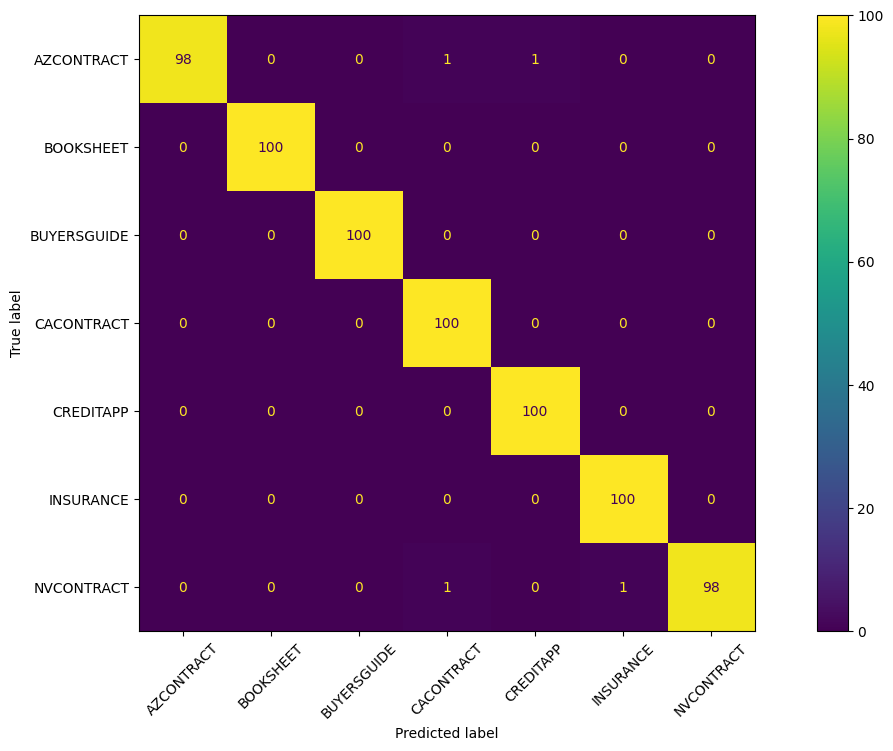

In [15]:
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels=DOCUMENT_CLASSES,
)
cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)

plt.show()